In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Click this button to open file in Colab
<a target="_blank" href="https://colab.research.google.com/github/ontaptom/workshops/blob/main/notebooks/ollama_functioncalling.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg">
</a>

# Run Open models with ollama and colab - for free

This notebook has been created for Warszawskie Dni Informatyki 2025. Feel free to make a copy and play with it.

When you connect to the Runtime, make sure to check

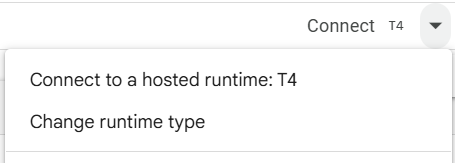

T4 GPU enabled runtime:

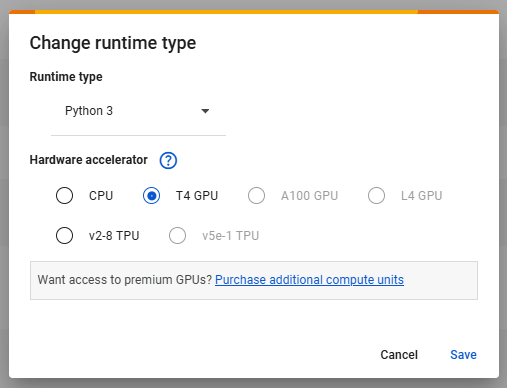

It can be used for free! There is daily quota - if you run out of quota, you will have to wait till the next day ;)

In [ ]:
# @title install ollama and PCI Utilities
!sudo apt-get install pciutils
!curl -fsSL https://ollama.com/install.sh | sh

In [ ]:
# @title Install Ollama Python library

!pip install -q ollama

In [ ]:
# @title Start Ollama using nohup

!nohup ollama serve > ollama.log &

In [ ]:
# @title Import ollama and pull llama3.2:3b

# check out https://ollama.com/library for other models


MODEL_ID = 'llama3.2:3b'
# MODEL_ID = 'functiongemma'

import ollama
ollama.pull(MODEL_ID)

In [ ]:
# @title Initialize Ollama Client

from ollama import Client
client = Client(host='http://localhost:11434')

In [ ]:
# @title Prosty test modelu (bez function calling)
prompt = "Powiedz cześć po polsku w jednym zdaniu"

response = client.chat(
    model=MODEL_ID,
    messages=[{"role": "user", "content": prompt}]
)
print(response['message']['content'])

In [ ]:
! ollama ps

In [ ]:
# @title Definicje funkcji (narzędzi)
import json

def sprawdz_pogode(miasto: str) -> str:
    """Sprawdza aktualną pogodę w podanym polskim mieście.

    Args:
        miasto: Nazwa miasta w Polsce, np. Warszawa, Kraków, Bydgoszcz
    """
    pogoda = {
        "warszawa": {"temperatura": "12°C", "opis": "słonecznie", "wilgotność": "45%"},
        "kraków": {"temperatura": "10°C", "opis": "zachmurzenie", "wilgotność": "60%"},
        "gdańsk": {"temperatura": "8°C", "opis": "deszczowo", "wilgotność": "80%"},
        "bydgoszcz": {"temperatura": "23°C", "opis": "słonecznie", "wilgotność": "40%"},
        "poznań": {"temperatura": "14°C", "opis": "pochmurno", "wilgotność": "55%"},
    }
    wynik = pogoda.get(miasto.lower(), {"błąd": f"Brak danych dla miasta {miasto}"})
    return json.dumps(wynik, ensure_ascii=False)


def przelicz_walute(kwota: float, z_waluty: str, na_walute: str) -> str:
    """Przelicza kwotę między walutami.

    Args:
        kwota: Kwota do przeliczenia
        z_waluty: Waluta źródłowa (np. PLN, EUR, USD)
        na_walute: Waluta docelowa (np. PLN, EUR, USD)
    """
    # Mock kursów względem PLN
    kursy_do_pln = {
        "PLN": 1.0,
        "EUR": 4.32,
        "USD": 4.05,
        "GBP": 5.12,
        "CHF": 4.55,
    }

    z_waluty = z_waluty.upper()
    na_walute = na_walute.upper()

    if z_waluty not in kursy_do_pln or na_walute not in kursy_do_pln:
        return json.dumps({"błąd": "Nieobsługiwana waluta"})

    # Przelicz przez PLN
    kwota_pln = kwota * kursy_do_pln[z_waluty]
    wynik = kwota_pln / kursy_do_pln[na_walute]

    return json.dumps({
        "kwota_wejściowa": f"{kwota} {z_waluty}",
        "kwota_wyjściowa": f"{wynik:.2f} {na_walute}",
        "kurs": f"1 {z_waluty} = {kursy_do_pln[z_waluty]/kursy_do_pln[na_walute]:.4f} {na_walute}"
    }, ensure_ascii=False)


def znajdz_restauracje(miasto: str, kuchnia: str = "dowolna") -> str:
    """Znajduje restauracje w podanym mieście.

    Args:
        miasto: Nazwa miasta
        kuchnia: Typ kuchni (np. polska, włoska, azjatycka, dowolna)
    """
    restauracje = {
        "bydgoszcz": {
            "polska": ["Stary Rynek 15", "Karczma u Bacy", "Bydgoska Pierogownia"],
            "włoska": ["Pasta La Vista", "Pizzeria Napoli"],
            "azjatycka": ["Hanoi Bistro", "Sushi Bydgoszcz"],
        },
        "warszawa": {
            "polska": ["Zapiecek", "Stary Dom", "Polka"],
            "włoska": ["Trattoria da Antonio", "Casa Mia"],
            "azjatycka": ["Bibimbap", "Stixx Bar & Grill"],
        },
        "kraków": {
            "polska": ["Pod Wawelem", "Starka", "Miód Malina"],
            "włoska": ["Aqua e Vino", "Padre"],
            "azjatycka": ["Edo Sushi", "Indus"],
        },
    }

    miasto_lower = miasto.lower()
    kuchnia_lower = kuchnia.lower()

    if miasto_lower not in restauracje:
        return json.dumps({"błąd": f"Brak danych dla miasta {miasto}"})

    if kuchnia_lower == "dowolna":
        wszystkie = []
        for typ, lista in restauracje[miasto_lower].items():
            wszystkie.extend([f"{r} ({typ})" for r in lista])
        return json.dumps({"restauracje": wszystkie[:5]}, ensure_ascii=False)

    if kuchnia_lower not in restauracje[miasto_lower]:
        return json.dumps({"błąd": f"Brak restauracji typu {kuchnia} w {miasto}"})

    return json.dumps({
        "miasto": miasto,
        "kuchnia": kuchnia,
        "restauracje": restauracje[miasto_lower][kuchnia_lower]
    }, ensure_ascii=False)


# Lista narzędzi do przekazania modelowi
tools = [sprawdz_pogode, przelicz_walute, znajdz_restauracje]

print("Zdefiniowane narzędzia:")
for t in tools:
    print(f"  - {t.__name__}: {t.__doc__.split(chr(10))[0]}")

In [ ]:
# @title Test pojedynczego wywołania funkcji

prompt = "Ile to jest 100 euro w złotówkach?"

response = client.chat(
    model=MODEL_ID,
    messages=[{"role": "user", "content": prompt}],
    tools=tools
)

print(f"Content: {response['message']['content']}")
print(f"Tool calls: {response['message'].get('tool_calls', 'brak')}")

In [ ]:
# @title Kompletny agent z obsługą wielu narzędzi

def agent_ollama(prompt: str, tools: list, debug: bool = False) -> str:
    """
    Agent realizujący function calling z Ollama.

    Args:
        prompt: Zapytanie użytkownika
        tools: Lista funkcji Pythona jako narzędzia
        debug: Czy wyświetlać szczegóły

    Returns:
        Końcowa odpowiedź modelu
    """
    # Mapowanie nazwa -> funkcja
    dostepne_funkcje = {f.__name__: f for f in tools}

    messages = [{"role": "user", "content": prompt}]

    # Pierwsze zapytanie
    response = client.chat(model=MODEL_ID, messages=messages, tools=tools)

    if debug:
        print("=== Odpowiedź modelu ===")
        print(f"Content: {response['message']['content'] or '(brak)'}")
        print(f"Tool calls: {response['message'].get('tool_calls', 'brak')}")

    tool_calls = response['message'].get('tool_calls', [])

    # Jeśli brak wywołań funkcji - zwróć odpowiedź
    if not tool_calls:
        return response['message']['content']

    # Dodaj odpowiedź asystenta do historii
    messages.append(response['message'])

    # Wykonaj każde wywołanie funkcji
    for tool_call in tool_calls:
        nazwa = tool_call['function']['name']
        args = tool_call['function']['arguments']

        if debug:
            print(f"\n=== Wywołanie: {nazwa}({args}) ===")

        if nazwa not in dostepne_funkcje:
            wynik = json.dumps({"błąd": f"Nieznana funkcja: {nazwa}"})
        else:
            try:
                wynik = dostepne_funkcje[nazwa](**args)
            except Exception as e:
                wynik = json.dumps({"błąd": str(e)})

        if debug:
            print(f"Wynik: {wynik}")

        messages.append({"role": "tool", "content": wynik})

    # Końcowe zapytanie z wynikami
    final = client.chat(model=MODEL_ID, messages=messages, tools=tools)

    if debug:
        print(f"\n=== Końcowa odpowiedź ===\n{final['message']['content']}")

    return final['message']['content']

In [ ]:
# @title Test: pogoda

odpowiedz = agent_ollama(
    "Jaka jest pogoda w Bydgoszczy?",
    tools,
    debug=True
)

In [ ]:
# @title Test: przelicznik walut

odpowiedz = agent_ollama(
    "Przelicz mi 250 dolarów na złotówki",
    tools,
    debug=True
)

In [ ]:
# @title Test: restauracje

odpowiedz = agent_ollama(
    "Znajdź mi jakąś włoską restaurację w Krakowie",
    tools,
    debug=True
)

In [ ]:
# @title Test: pytanie wymagające wielu narzędzi

odpowiedz = agent_ollama(
    "Jadę do Bydgoszczy. Jaka tam teraz pogoda i gdzie mogę zjeść coś polskiego?",
    tools,
    debug=True
)

Dodajmy "prawdziwą" funkcję, która sprawdza pogodę

In [ ]:
# Let's access some external API!

# Source: dane.gov.pl

# https://dane.gov.pl/pl/dataset/2913,dane-pomiarowe-esa-edukacyjna-siec-antysmogowa/resource/43585/table


import requests

def air_quality(miasto: str) -> str:
    """Sprawdza pogodę w tym temperaturę i jakość powietrza w podanym mieście.

    Args:
        miasto: Nazwa miasta, np. Bydgoszcz, Warszawa, Kraków
    """

    url = 'https://public-esa.ose.gov.pl/api/v1/smog'

    try:
        response = requests.get(url)
        response.raise_for_status()

        all_data = response.json()['smog_data']
        city_data = [entry for entry in all_data if entry['school']['city'].upper() == miasto.upper()]

        if not city_data:
            return f"No air quality data available for {miasto}"

        results = []
        for entry in city_data:
            data = entry['data']
            results.append({
                'Temperature': data['temperature_avg'],
                'PM10': data['pm10_avg'],
                'PM2.5': data['pm25_avg'],
                'Timestamp': entry['timestamp'],
                'Street': entry['school']['street'],
                'City': miasto
            })

        return str(results[0])
    except requests.exceptions.HTTPError as errh:
        return "Http Error:", errh
    except requests.exceptions.ConnectionError as errc:
        return "Error Connecting:", errc
    except requests.exceptions.Timeout as errt:
        return "Timeout Error:", errt
    except requests.exceptions.RequestException as err:
        return "Oops: Something Else", err
    except KeyError as e:
        return "Data format error: Key not found in response.", e


In [ ]:
# Lista narzędzi do przekazania modelowi
tools = [air_quality, przelicz_walute, znajdz_restauracje]

In [ ]:
# @title Test: pytanie wymagające wielu narzędzi

odpowiedz = agent_ollama(
    "Jadę do Bydgoszczy. Jaka tam teraz pogoda i gdzie mogę zjeść coś polskiego?",
    tools,
    debug=True
)